In [1]:
import nltk
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem.porter import *
from tokenizer import tokenizer
from nltk.corpus import stopwords
from sklearn.linear_model import *
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.utils import plot_model
import contractions as cont_lib
from tqdm import tqdm
import re
import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv('twitter-2013train-A.txt',sep="\t",names=['ID','emotion','text'])
df

,ID,emotion,text
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I\u2019m going t...
1,263405084770172928,negative,Theo Walcott is still shit\u002c watch Rafa an...
2,262163168678248449,negative,its not that I\u2019m a GSP fan\u002c i just h...
3,264249301910310912,negative,Iranian general says Israel\u2019s Iron Dome c...
4,262682041215234048,neutral,Tehran\u002c Mon Amour: Obama Tried to Establi...
...,...,...,...
9679,103158179306807296,positive,RT @MNFootNg It's monday and Monday Night Foot...
9680,103157324096618497,positive,All I know is the road for that Lomardi start ...
9681,100259220338905089,neutral,"All Blue and White fam, we r meeting at Golden..."
9682,104230318525001729,positive,@DariusButler28 Have a great game agaist Tam...


# Data Preprocessing

In [3]:
#Cleaning the tweets
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def clean(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'pic.twitter\S+', ' ', text)
    text = decontracted(text)
    text = re.sub(r'\(([^)]+)\)', " ", text)
    text = re.sub('@[\w]+','',text)
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)
    text = re.sub(r' \w{1,2}_', ' ', text)
    text = re.sub('\s+',' ', text)
    return text

In [4]:
for i in tqdm(df.itertuples()):
    df.at[i[0], 'tweet'] = clean(i[3])

9684it [00:00, 33385.64it/s]


In [5]:
data = df[['emotion','tweet']].copy()

In [6]:
data

,emotion,tweet
0,positive,gas by my house hit i u m going to chapel hill...
1,negative,theo walcott is still shit u c watch rafa and ...
2,negative,its not that i u m a gsp fan u c i just hate n...
3,negative,iranian general says israel u s iron dome can ...
4,neutral,tehran u c mon amour obama tried to establish ...
...,...,...
9679,positive,rt it is monday and monday night football is o...
9680,positive,all i know is the road for that lomardi start ...
9681,neutral,all blue and white fam we r meeting at golden ...
9682,positive,have a great game agaist tampa bay tonight


# WordCloud

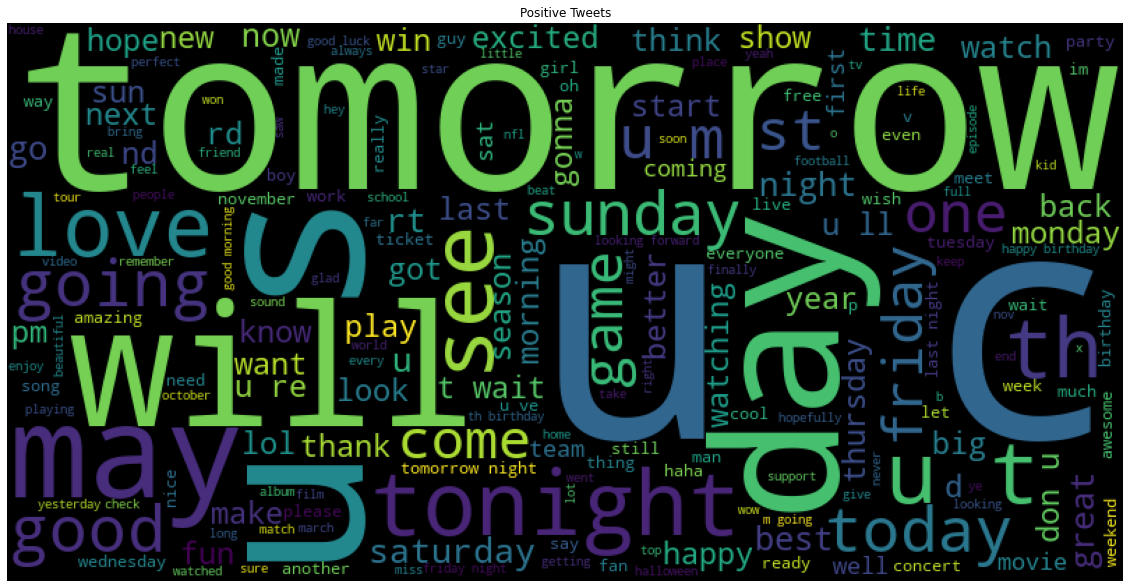

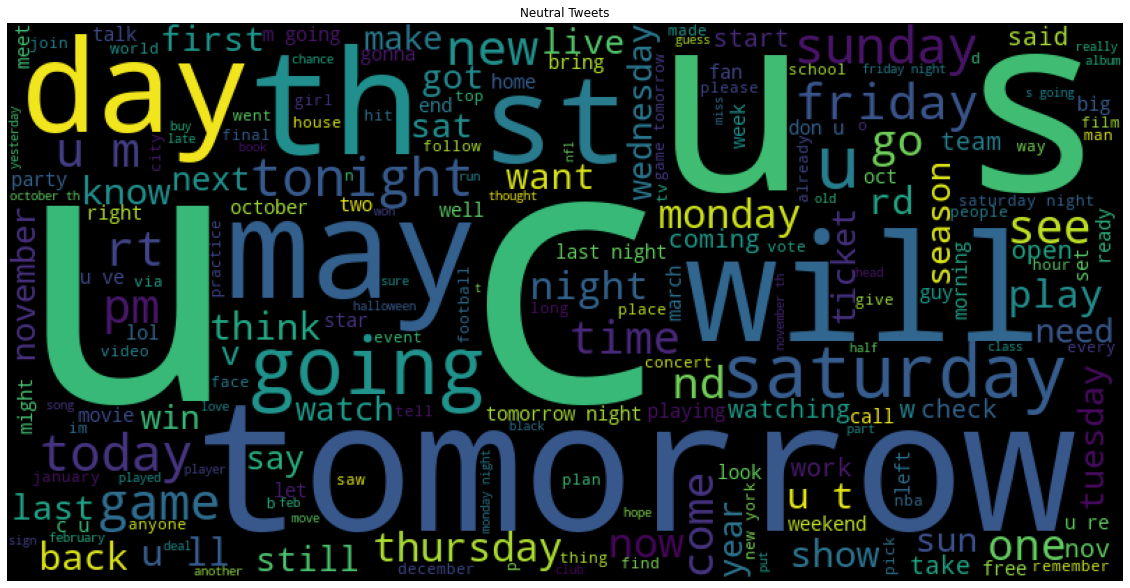

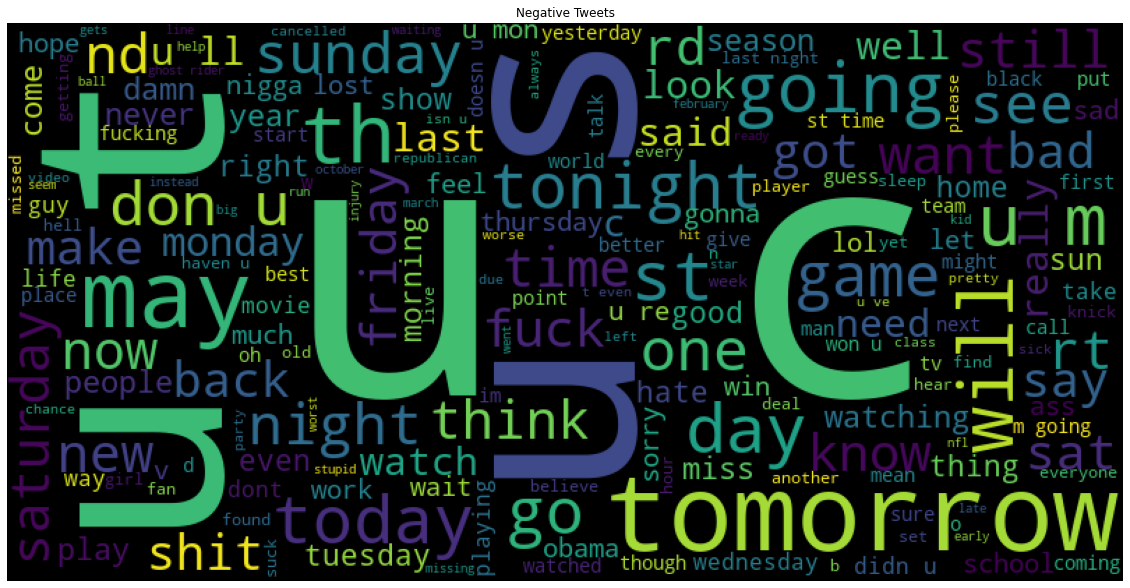

In [7]:
from wordcloud import WordCloud

df_pos = data.loc[df["emotion"] == 'positive']
df_neu = data.loc[df["emotion"] == 'neutral']
df_neg = data.loc[df["emotion"] == 'negative']

wc_pos = WordCloud(
    width = 800, 
    height = 400, 
).generate(" ".join(df_pos["tweet"])) 

wc_neu = WordCloud(
    width = 800, 
    height = 400, 
).generate(" ".join(df_neu["tweet"])) 

wc_neg = WordCloud(
    width = 800, 
    height = 400, 
).generate(" ".join(df_neg["tweet"])) 

plt.figure(figsize = (20,20))
plt.imshow(wc_pos)
plt.title("Positive Tweets")
plt.axis("off")
plt.show()

plt.figure(figsize = (20,20))
plt.imshow(wc_neu)
plt.title("Neutral Tweets")
plt.axis("off")
plt.show()

plt.figure(figsize = (20,20))
plt.imshow(wc_neg)
plt.title("Negative Tweets")
plt.axis("off")
plt.show()


# Split the Data

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [9]:
num_words = 10000

tokenizer = Tokenizer(num_words=num_words, lower=True)
tokenizer.fit_on_texts(data.tweet)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
data

,emotion,tweet
0,positive,gas by my house hit i u m going to chapel hill...
1,negative,theo walcott is still shit u c watch rafa and ...
2,negative,its not that i u m a gsp fan u c i just hate n...
3,negative,iranian general says israel u s iron dome can ...
4,neutral,tehran u c mon amour obama tried to establish ...
...,...,...
9679,positive,rt it is monday and monday night football is o...
9680,positive,all i know is the road for that lomardi start ...
9681,neutral,all blue and white fam we r meeting at golden ...
9682,positive,have a great game agaist tampa bay tonight


In [12]:
train = pd.DataFrame(columns=['emotion', 'tweet'])
validation = pd.DataFrame(columns=['emotion', 'tweet'])
test = pd.DataFrame(columns=['emotion', 'tweet'])
for emotion in data.emotion.unique():
    emotion_data = data[data.emotion == emotion]
    train_data, validation_data = train_test_split(emotion_data, test_size=0.2)
    train_data, test_data = train_test_split(train_data, test_size=0.25)
    train = pd.concat([train, train_data])
    validation = pd.concat([validation, validation_data])
    test =  pd.concat([test, test_data])

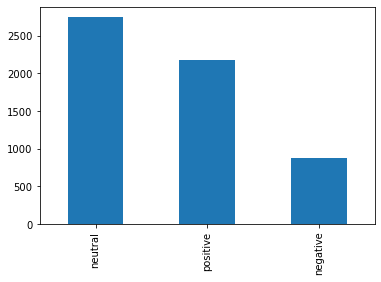

In [13]:
class_dist = train.emotion.value_counts()
class_dist.plot(kind='bar')
plt.show()

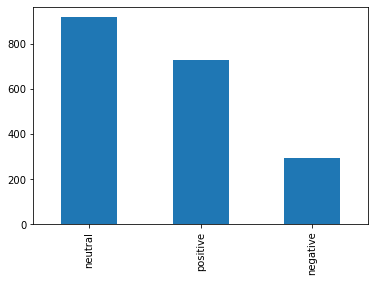

In [14]:
class_dist = validation.emotion.value_counts()
class_dist.plot(kind='bar')
plt.show()

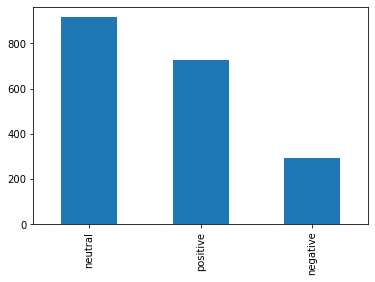

In [15]:
class_dist = test.emotion.value_counts()
class_dist.plot(kind='bar')
plt.show()

In [16]:
train

,emotion,tweet
9076,positive,skipping school tomorrow and going to tennesse...
1101,positive,balletcenter in cebu is holding romeo and juli...
2794,positive,yeay hopefully runman ep with eng sub will be ...
6752,positive,had a little trip out to the old town of albuq...
1542,positive,i cut th period just so kevin didnt have to be...
...,...,...
2358,neutral,injures borderland u ctaking him out of the p...
4296,neutral,umm they have these two players u c you may n...
4739,neutral,ah u c you u re a bee charmer you touch wood ...
7641,neutral,roman abramovich has pulled the plug on a poss...


In [17]:
validation

,emotion,tweet
7810,positive,had a dream i arrived at sjp an hour before ki...
6556,positive,can not wait to go to the movies on saturday t...
2938,positive,new haven ct come to the teen center and party...
9563,positive,tonite it goes down street fm on fm in ny broa...
5928,positive,wow and pink friday has got to number in the a...
...,...,...
4308,neutral,estella has become really dramatic all of a su...
3762,neutral,i may or may not be in love with carrie underwood
4941,neutral,days away barack obama mitt romney meet in th...
150,neutral,i told you shane would get his th star on riv...


In [18]:
test

,emotion,tweet
7654,positive,catherinebelll i watched good witch for the s...
5800,positive,almost forgot about celebrity juice tonight oh...
6105,positive,im getting horny hey that reminds me is it the...
7085,positive,hiya good morning raining in scotland today m...
5058,positive,bitch u shoulda came with me saturday sooooo ...
...,...,...
3414,neutral,at the bootleg the last weekend of september ...
1647,neutral,the memorial of his grace bishop samuel may he...
1087,neutral,jimmy kimmel live axl rose u c part part of ji...
7099,neutral,purples and football at baby a is with my aunt...


# MODEL

In [19]:
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional, Conv1D, Dense, concatenate
from tensorflow.keras.models import Model

In [20]:
input_dim = min(tokenizer.num_words, len(tokenizer.word_index) + 1)
num_classes = len(data.emotion.unique())
embedding_dim = 500
input_length = 100
lstm_units = 128
lstm_dropout = 0.1
recurrent_dropout = 0.1
spatial_dropout=0.2
filters=64
kernel_size=3

In [21]:
input_layer = Input(shape=(input_length,))
output_layer = Embedding(
  input_dim=input_dim,
  output_dim=embedding_dim,
  input_shape=(input_length,)
)(input_layer)

output_layer = SpatialDropout1D(spatial_dropout)(output_layer)

output_layer = Bidirectional(
LSTM(lstm_units, return_sequences=True,
     dropout=lstm_dropout, recurrent_dropout=recurrent_dropout)
)(output_layer)
output_layer = Conv1D(filters, kernel_size=kernel_size, padding='valid',
                    kernel_initializer='glorot_uniform')(output_layer)

avg_pool = GlobalAveragePooling1D()(output_layer)
max_pool = GlobalMaxPooling1D()(output_layer)
output_layer = concatenate([avg_pool, max_pool])

output_layer = Dense(num_classes, activation='softmax')(output_layer)

model = Model(input_layer, output_layer)

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 500)     5000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 100, 500)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 256)     644096      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

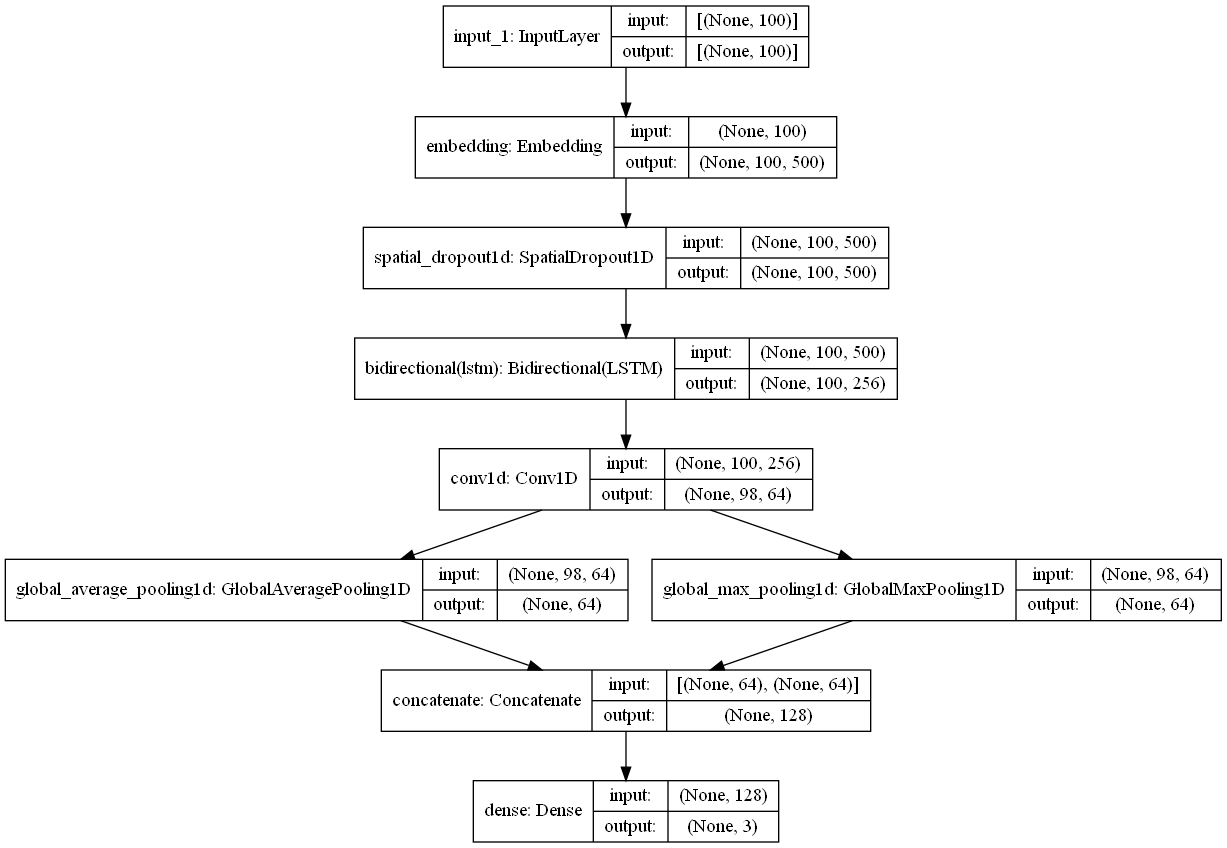

In [23]:
plot_model(model, to_file = 'LSTM-CNN.png', show_shapes = True, show_layer_names = True)

In [56]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer

In [57]:
train_sequences = [tweet.split() for tweet in train.tweet]
validation_sequences = [tweet.split() for tweet in validation.tweet]
test_sequences = [tweet.split() for tweet in test.tweet]
list_tokenized_train = tokenizer.texts_to_sequences(train_sequences)
list_tokenized_validation = tokenizer.texts_to_sequences(validation_sequences)
list_tokenized_test = tokenizer.texts_to_sequences(test_sequences)
x_train = pad_sequences(list_tokenized_train, maxlen=input_length)
x_validation = pad_sequences(list_tokenized_validation, maxlen=input_length)
x_test = pad_sequences(list_tokenized_test, maxlen=input_length)

encoder = LabelBinarizer()
encoder.fit(data.emotion.unique())

y_train = encoder.transform(train.emotion)
y_validation = encoder.transform(validation.emotion)
y_test = encoder.transform(test.emotion)

In [58]:
batch_size = 128
epochs = 10

In [59]:
history = model.fit(
            x=x_train,
            y=y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_validation, y_validation)
        )

Epoch 1/10
46/46 [==============================] - 52s 958ms/step - loss: 0.9864 - accuracy: 0.5099 - val_loss: 0.9140 - val_accuracy: 0.5800
Epoch 2/10
46/46 [==============================] - 38s 836ms/step - loss: 0.7123 - accuracy: 0.6981 - val_loss: 0.7875 - val_accuracy: 0.6672
Epoch 3/10
46/46 [==============================] - 39s 851ms/step - loss: 0.3902 - accuracy: 0.8523 - val_loss: 0.9281 - val_accuracy: 0.6538
Epoch 4/10
46/46 [==============================] - 40s 869ms/step - loss: 0.2097 - accuracy: 0.9244 - val_loss: 1.1293 - val_accuracy: 0.6373
Epoch 5/10
46/46 [==============================] - 40s 880ms/step - loss: 0.1108 - accuracy: 0.9645 - val_loss: 1.4936 - val_accuracy: 0.6207
Epoch 6/10
46/46 [==============================] - 40s 866ms/step - loss: 0.0643 - accuracy: 0.9814 - val_loss: 1.7122 - val_accuracy: 0.6130
Epoch 7/10
46/46 [==============================] - 39s 858ms/step - loss: 0.0414 - accuracy: 0.9900 - val_loss: 2.0270 - val_accuracy: 0.6192

# Plot

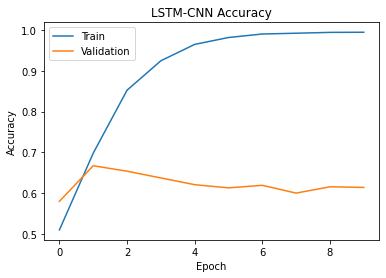

In [60]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM-CNN Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

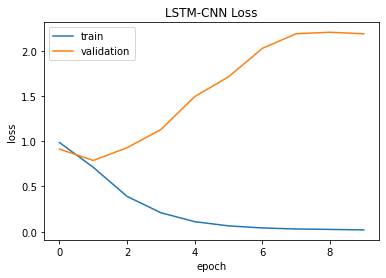

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM-CNN Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [68]:
y_pred = model.predict(x_test)

In [69]:
y_pred_1d = y_pred.argmax(axis=1)
y_test_1d = y_test.argmax(axis=1)

# Classification Report

In [71]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

           0       0.53      0.40      0.45       292
           1       0.69      0.72      0.70       917
           2       0.65      0.67      0.66       728

    accuracy                           0.65      1937
   macro avg       0.62      0.60      0.61      1937
weighted avg       0.65      0.65      0.65      1937



In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(f"accuracy：{accuracy_score(y_test_1d, y_pred_1d)}")
print(f"precision：{precision_score(y_test_1d, y_pred_1d, average='micro')}")
print(f"recall：{recall_score(y_test_1d, y_pred_1d, average='micro')}")
print(f"F1-score：{f1_score(y_test_1d, y_pred_1d, average='micro')}")

accuracy：0.6530717604543108
precision：0.6530717604543108
recall：0.6530717604543108
F1-score：0.6530717604543108


In [82]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

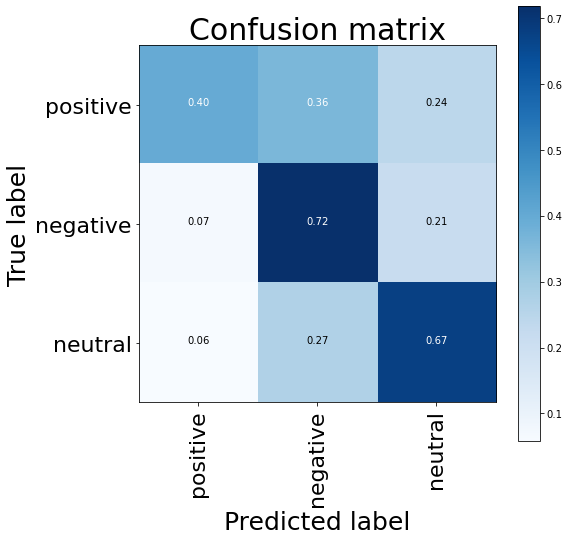

In [85]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=train.emotion.unique(), title="Confusion matrix")
plt.show()